# Exploring Clustering Methods: Using Credit Card Dataset 2


## Data Exploration <a class="anchor" id="first-bullet"></a>

First, let us import the required libraries.

In [118]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.cluster import mean_shift, estimate_bandwidth
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer, silhouette_visualizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from tqdm import tqdm

In [119]:
import warnings
warnings.filterwarnings("ignore")

In [120]:
data = pd.read_csv('./CC Data 2.csv')

Lets have a look at some rows of the dataset:

In [121]:
data.head()

,Customer Age,Gender,Education Level,Marital Status,Months on book,Credit Limit,Total Trans Amt,Total Trans Count,Minimum income,Max income
0,45,M,High School,Married,39,12691,1144,42,60000,80000
1,49,F,Graduate,Single,44,8256,1291,33,0,40000
2,51,M,Graduate,Married,36,3418,1887,20,80000,120000
3,40,F,High School,Unknown,34,3313,1171,20,0,40000
4,40,M,Uneducated,Married,21,4716,816,28,60000,80000


As one can easily see, teh dataset has 18 features with about 9000 samples.

In [122]:
data.shape

(10127, 10)

Now, we can see the data types of the features:

In [123]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Customer Age       10127 non-null  int64 
 1   Gender             10127 non-null  object
 2   Education Level    10127 non-null  object
 3   Marital Status     10127 non-null  object
 4   Months on book     10127 non-null  int64 
 5   Credit Limit       10127 non-null  int64 
 6   Total Trans Amt    10127 non-null  int64 
 7   Total Trans Count  10127 non-null  int64 
 8   Minimum income     10127 non-null  int64 
 9   Max income         10127 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 791.3+ KB


Lets have a copy of the data for the later use:

In [124]:
data_raw = data.copy()

In the following, we investigate the number of different values in all features to understand whether there exist any binary features or not. Furthermore, to decide which features are redundant and can be deleted.

In [125]:
unique_dict = dict()
for col in data.columns:
    unique_dict[col] = data[col].value_counts().count()

pd.Series(unique_dict).to_frame().rename(columns={0: 'Number of unique values'})

,Number of unique values
Customer Age,45
Gender,2
Education Level,7
Marital Status,4
Months on book,44
Credit Limit,6205
Total Trans Amt,5033
Total Trans Count,126
Minimum income,5
Max income,5


As one can see, we do not have any binary features. Furthermore, for each sample we have a CUST_ID which can be omitted wihtout losing any information. 

In what follows, let's have a look at the pairwise correlation of columns:

In [126]:
data.drop(columns=['Gender', 'Education Level', 'Marital Status'], axis=1, inplace=True)

In [127]:
data.corr().T

,Customer Age,Months on book,Credit Limit,Total Trans Amt,Total Trans Count,Minimum income,Max income
Customer Age,1.000000,0.788912,0.002417,-0.046446,-0.067097,0.024604,0.020018
Months on book,0.788912,1.000000,0.007337,-0.038591,-0.049819,0.022522,0.020281
Credit Limit,0.002417,0.007337,1.000000,0.172786,0.076164,0.509120,0.435418
Total Trans Amt,-0.046446,-0.038591,0.172786,1.000000,0.807192,0.018627,0.019553
Total Trans Count,-0.067097,-0.049819,0.076164,0.807192,1.000000,-0.053752,-0.054171
Minimum income,0.024604,0.022522,0.509120,0.018627,-0.053752,1.000000,0.919428
Max income,0.020018,0.020281,0.435418,0.019553,-0.054171,0.919428,1.000000


The descriptive statistics of our dataset is as follows:

In [128]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer Age,10127.0,46.325960,8.016814,26.0,41.0,46.0,52.0,73.0
Months on book,10127.0,35.928409,7.986416,13.0,31.0,36.0,40.0,56.0
Credit Limit,10127.0,8559.946381,9150.975221,0.0,2555.0,4549.0,11067.5,34516.0
Total Trans Amt,10127.0,4404.086304,3397.129254,510.0,2155.5,3899.0,4741.0,18484.0
Total Trans Count,10127.0,64.858695,23.472570,10.0,45.0,67.0,81.0,139.0
Minimum income,10127.0,36117.310161,38480.075870,0.0,0.0,40000.0,60000.0,120000.0
Max income,10127.0,62549.619828,37270.290345,0.0,40000.0,60000.0,80000.0,120000.0


Using histograms, one can see the distributions of the features in our dataset:

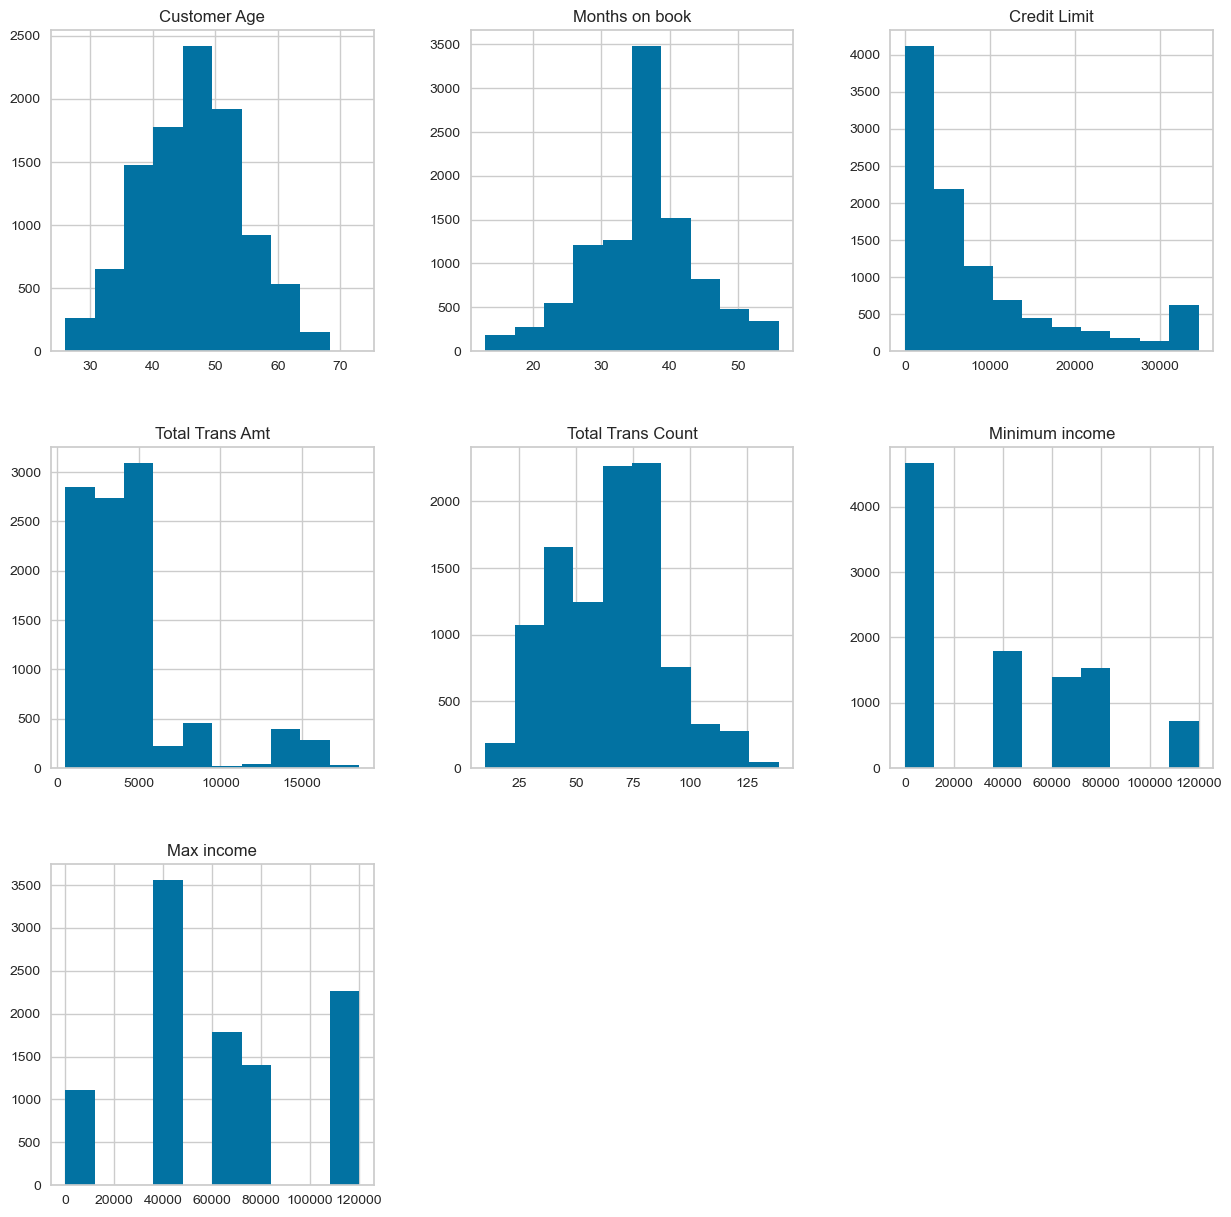

In [129]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
data.hist(figsize=(15, 15))
plt.show()


## Data Cleaning <a class="anchor" id="second-bullet"></a>

Now that we have have got familiar with the dataset, it is time to clean the data to tackle our problem:

### Handeling Skewness  <a class="anchor" id="21"></a>

As the first step to clean our data, lets investigate the skewness of our feature:

<Axes: >

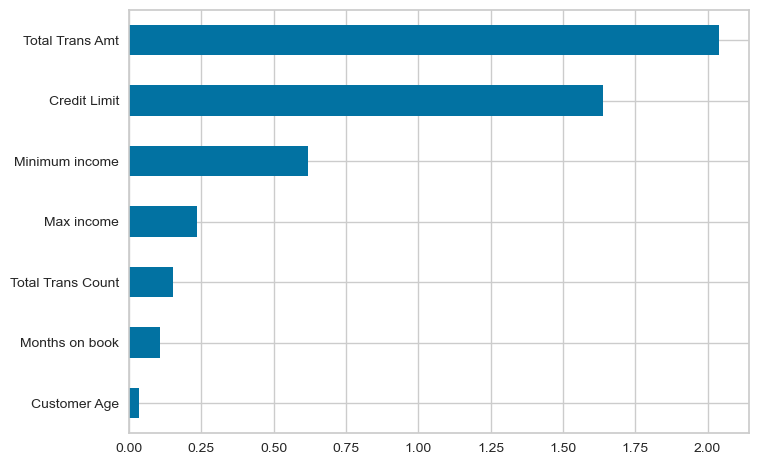

In [130]:
skew_val = data.skew().abs().sort_values()
skew_val.plot.barh()

As one can see, many of our features are highly skewed, and we have to take care of them. Using a log transformation, we can reduce the skewness of the features:

In [131]:
skewed_col = data.columns[skew_val>0.7]

<Axes: >

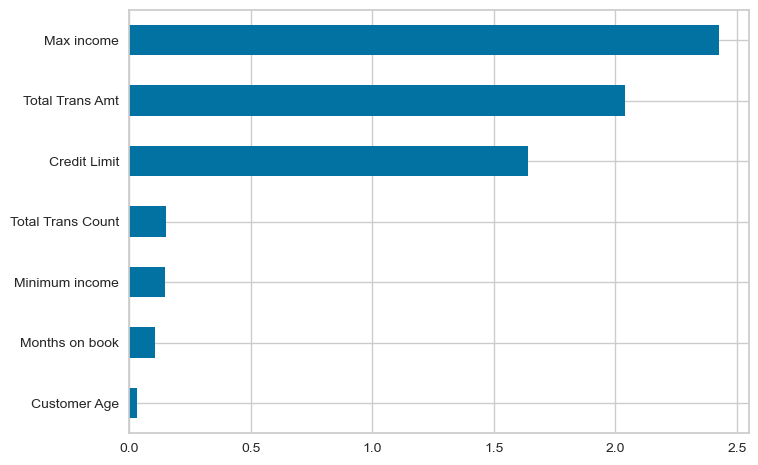

In [132]:
for col in skewed_col:
    data[col] = np.log1p(data[col])
    
skew_val = data.skew().abs().sort_values()
skew_val.plot.barh()

Employing the two barcharts provided above, it can be easily seen that the skewness has been decreases using the proposed transformation.

### Deleting Outliers <a class="anchor" id="22"></a>

In this subsection, we consider inspecting the outliers in our dataset. Using boxplots, we can display the distribution of the dataset and to visually detect the outliers in the dataset. 

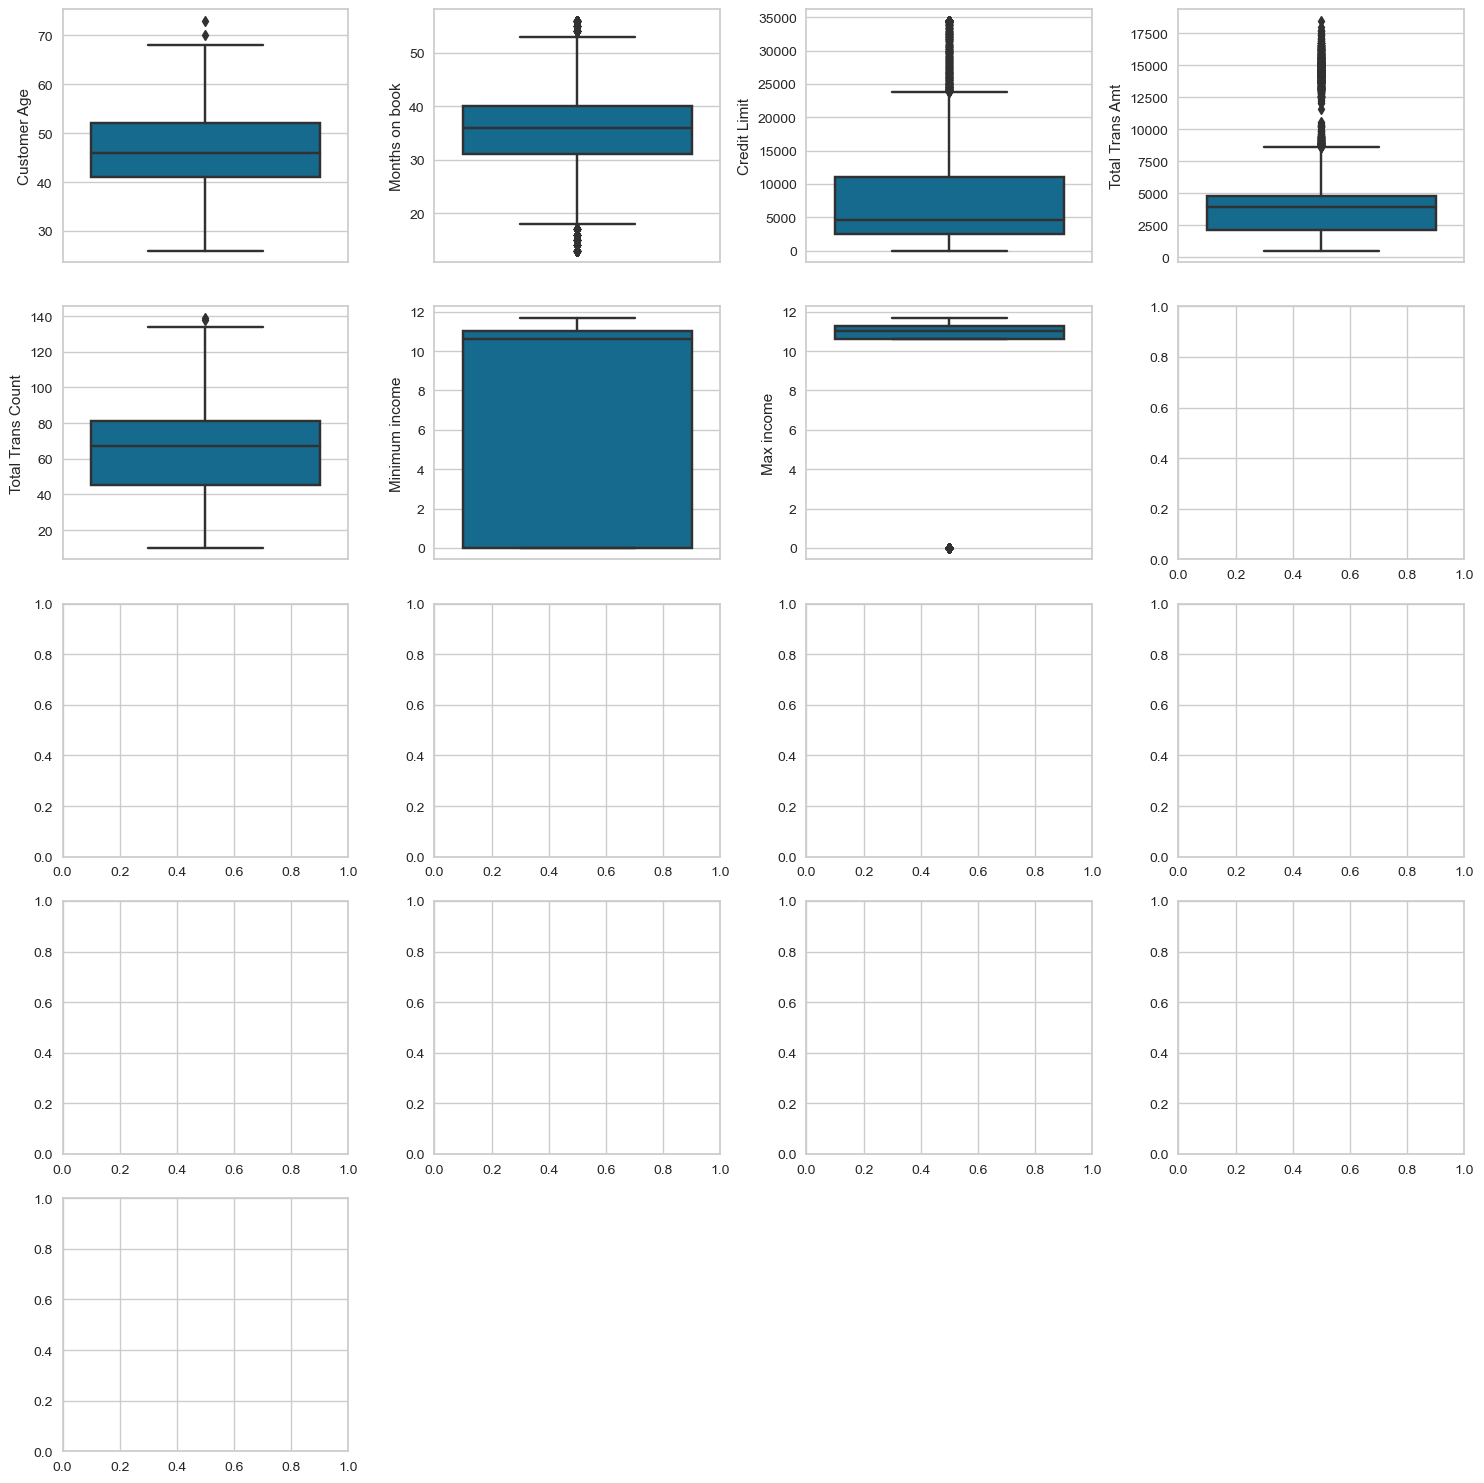

In [133]:
def bar_plot_rep(data):
    _, ax = plt.subplots(5,4, figsize=(15,15))
    for num, col in enumerate(data.columns):
        sns.boxplot(y=col, data=data, ax=ax.ravel()[num])
    
    plt.tight_layout()
    ax.ravel()[17].axis('off'), ax.ravel()[18].axis('off'), ax.ravel()[19].axis('off')
    plt.show()
    
bar_plot_rep(data)

We consider z-core=5 as a limit to delete the outliers in our dataset.

In [134]:
SScaler = StandardScaler()
data_scaled = SScaler.fit_transform(data)
mask = np.all(np.abs(data_scaled) < 5, axis=1)

data_del_outliers = data[mask]
data = data_del_outliers
data.shape

(10127, 7)

### Handling Null Values <a class="anchor" id="23"></a>

Let's again have a look at the features to see whether there exist any null values in our dataset.

In [135]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Customer Age       10127 non-null  int64  
 1   Months on book     10127 non-null  int64  
 2   Credit Limit       10127 non-null  int64  
 3   Total Trans Amt    10127 non-null  int64  
 4   Total Trans Count  10127 non-null  int64  
 5   Minimum income     10127 non-null  float64
 6   Max income         10127 non-null  float64
dtypes: float64(2), int64(5)
memory usage: 553.9 KB


### Applying PCA <a class="anchor" id="25"></a>

We consider PCA to reduce the dimension to improve the clustering performance. Suppose that we want to preserve 90 percent of the variance.  To do so, it is enough to consider 5 components in the PCA and 6 components in the PCA with Kernel, as it becomes clear below. PCA is used to find new standarized data based on relations between each variables.

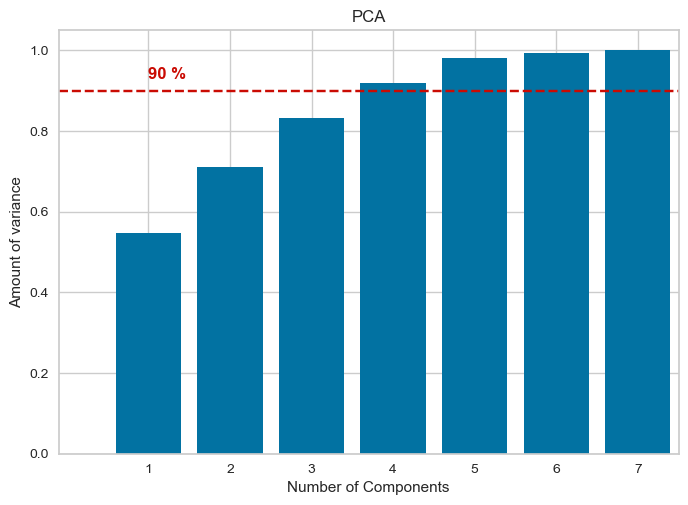

In [136]:
max_abs_scal = MaxAbsScaler()
pca = PCA(n_components=7, random_state=1979)

data_sca = max_abs_scal.fit_transform(data)
data_sca_tra = pca.fit_transform(data_sca)

res = pca.explained_variance_ratio_
plt.bar(x=np.arange(1,8), height=np.cumsum(res))
plt.text(1,0.93, '90 %', fontweight='bold', color='r')
plt.plot([-0.1, 7.5], [0.90,0.90], 'r--')
ax = plt.gca()
ax.set(xticks=np.arange(1,8), xlabel='Number of Components', ylabel='Amount of variance', title='PCA', xlim=[-0.1, 7.5])
plt.show()

### Applying PCA with Kernal <a class="anchor" id="25"></a>

PCA is not enough as ideally data can be quite varied and the relation maybe non-linear in nature. So PCA with kernel can identify non-linear relations. 

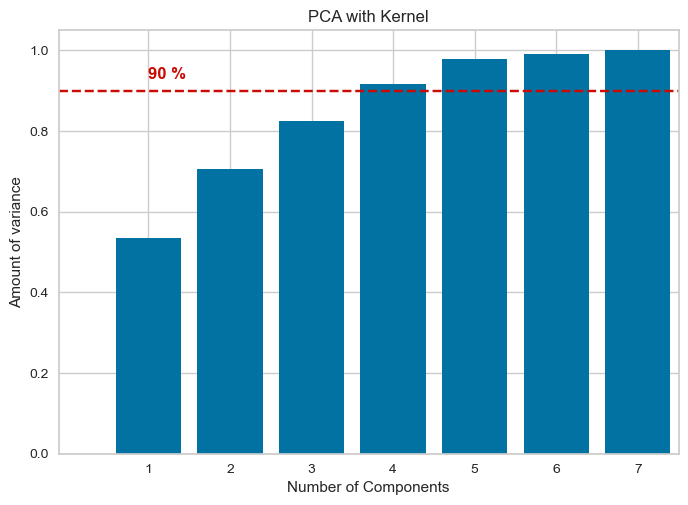

In [137]:
max_abs_scal = MaxAbsScaler()
kern_pca = KernelPCA(n_components=7, n_jobs=-1, kernel='rbf', random_state=1979)

data_sca = max_abs_scal.fit_transform(data)
data_sca_tra = kern_pca.fit_transform(data_sca)

explained_variance = np.var(data_sca_tra, axis=0)
res = explained_variance / np.sum(explained_variance)

plt.bar(x=np.arange(1,8), height=np.cumsum(res))

plt.text(1,0.93, '90 %', fontweight='bold', color='r')
plt.plot([-0.1, 7.5], [0.90,0.90], 'r--')
ax = plt.gca()
ax.set(xticks=np.arange(1,8), xlabel='Number of Components', ylabel='Amount of variance', title='PCA with Kernel', xlim=[-0.1, 7.5])
plt.show()



## Mean Shift Clustering <a class="anchor" id="34"></a>

The method that we have considered is the Mean Shift Clustering approach. Mean Shift essentially uses the Bandwidth values whihc is used to determine th esize of the nieghborhood used for clustering 

# 1. Evaluation Metrics for Mean Shift

In [138]:
def plot_num_cat(data, feature, target, figsize=None):
    fig = plt.figure(figsize=(15,6))

    for value in data[target].unique():
        sns.kdeplot(data[data[target]==value][feature])

    fig.legend(labels=data[target].unique())
    plt.title('{} distribution based on {}'.format(feature, target))
    plt.show()

In [140]:
from sklearn import metrics

def evaluate_clustering(labels, data):
    # Calculate Silhouette score
    silhouette_score = metrics.silhouette_score(data, labels, metric='euclidean')

    # Calculate Davies-Bouldin Index
    davies_bouldin_index = metrics.davies_bouldin_score(data, labels)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz_index = metrics.calinski_harabasz_score(data, labels)

    return silhouette_score, davies_bouldin_index, calinski_harabasz_index

In [141]:
from sklearn.neighbors import NearestNeighbors
def find_best_eps(data, min_samples):
    # Step 1: Calculate the average distance between each point in the data set and its K nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=min_samples).fit(data)
    distances, indices = nbrs.kneighbors(data)

    # Get the distance to the furthest neighbor (last column of sorted distances)
    k_distances = distances[:, -1]

    # Step 2: Sort distance values by ascending order and plot the K-distance graph
    sorted_distances = np.sort(k_distances)

    # Step 3: Find the elbow point in the graph and use the corresponding distance as Epsilon
    diffs = np.diff(sorted_distances)

    max_diff_index = np.argmax(diffs)

    plt.plot(sorted_distances)
    plt.xlabel('Data point index')
    plt.ylabel(f'Distance to {min_samples}-th nearest neighbor')
    #plt.yticks(np.arange(min(sorted_distances), max(sorted_distances)+1, 1))

    #plt.plot(max_diff_index, sorted_distances[max_diff_index], 'ro')

    plt.show()
    

Shape of filtered_data: (10127, 7)


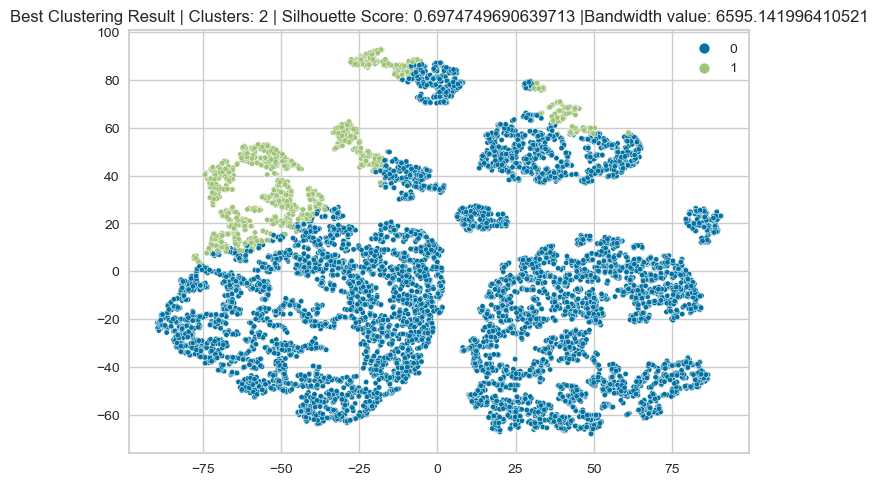

In [143]:
from sklearn.cluster import MeanShift
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import estimate_bandwidth
from sklearn.metrics import silhouette_score

# Create the Mean Shift object with bandwidth (similar to epsilon)
bandwidth = estimate_bandwidth(data, quantile=0.3, n_samples=None, random_state=1979, n_jobs=-1)
mean_shift = MeanShift(bandwidth=bandwidth)

# Fit the Mean Shift model to your scaled data
mean_shift.fit(data)

# Get cluster labels
cluster_labels = mean_shift.labels_

# Remove noise (label -1) data points
noise_mask = cluster_labels != -1
filtered_data = data[noise_mask]
filtered_labels = cluster_labels[noise_mask]

# Calculate silhouette score without noise
mean_shift_silhouette = silhouette_score(filtered_data, filtered_labels)

# Check the shape of filtered_data
print("Shape of filtered_data:", filtered_data.shape)

# Convert filtered_data to a NumPy array
filtered_data_np = filtered_data.values

# # Create a custom color mapping for each cluster label
# label_colors = plt.cm.get_cmap('nipy_spectral', len(np.unique(filtered_labels)))

# # Create a scatter plot with different colors for each cluster
# plt.scatter(filtered_data_np[:, 0], filtered_data_np[:, 1], c=label_colors(filtered_labels), cmap='nipy_spectral')

# plt.title('Visualization of Mean Shift clustered data')
# plt.show()
# Plot the best clustering result
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

colors = sns.color_palette(n_colors=len(np.unique(filtered_labels)))
tsne = TSNE(n_components=2, learning_rate='auto', random_state=58).fit_transform(data_sca_tra)
sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], s=15, hue=filtered_labels, palette=colors)
plt.title(f'Best Clustering Result | Clusters: {len(np.unique(filtered_labels))} | Silhouette Score: {mean_shift_silhouette} |Bandwidth value: {bandwidth}' )
plt.show()


In [144]:
print(len(set(filtered_labels)))

2


In [145]:
# # I see alot of clusters
mean_shift_data = data[noise_mask].copy()
mean_shift_data['mean_shift_cluster'] = filtered_labels

In [146]:
cluster_mean_shift = mean_shift_data.groupby('mean_shift_cluster').mean().T
cm = sns.light_palette("red", as_cmap=True)
cluster_mean_shift = cluster_mean_shift.style.background_gradient(cmap=cm)
cluster_mean_shift

mean_shift_cluster,0,1
Customer Age,46.320280,46.360817
Months on book,35.919384,35.983791
Credit Limit,5347.710955,28272.522903
Total Trans Amt,4233.990354,5447.916843
Total Trans Count,64.296624,68.307963
Minimum income,5.280932,10.034474
Max income,9.777443,10.267428


In [150]:
mean_shift_avg_distance = average_cluster_distance(filtered_labels, filtered_data)

for index, dist in enumerate(mean_shift_avg_distance):
    print(f'(mean_shift) Average distance between members of Cluster {index}: {dist}')

(mean_shift) Average distance between members of Cluster 0: 6068.169347439168
(mean_shift) Average distance between members of Cluster 1: 9131.73956013212


In [151]:
mean_shift_silhouette, mean_shift__davies_bouldin, mean_shift__calinski_harabasz = evaluate_clustering(filtered_labels, filtered_data )

print(f'mean_shift Silhouette score: {mean_shift_silhouette}')
print(f'mean_shift Davies-Bouldin Index: {mean_shift__davies_bouldin}')
print(f'mean_shift Calinski-Harabasz Index: {mean_shift__calinski_harabasz}')

mean_shift Silhouette score: 0.6974749690639713
mean_shift Davies-Bouldin Index: 0.4924619569818694
mean_shift Calinski-Harabasz Index: 20234.921705111763


# 2. Experimentation of the Mean Shift Clustering method (PCA and PCA with Kernel)

Now, let us tune the hyperparameters to obtain different results. We have preset the scaler as 'MaxAbsScale()'. Then, we will search for the optimal values for bandwidth and transformer (i.e. PCA or KernelPCA). 

The code performs clustering for multiple combinations of bandwidth and transformer values and calculate the silouhette score for each. For each cluster label it picks out the value with the highest sillouhette score after testing with all possible bandwidth and Transformer type combinations. 

So for each cluster label, the combination with the highest sillouhette score is filtered out and the best transformer( PCA or Kernel PCA) is chosen and the mean shift clustering is performed once again on the most optimal combination to get the best performing clusters' cluster label and silhouette score and the best cluster label value is returned.

In [ ]:
def mean_shift_clusterer(X, random_state=1979, bandwidth=None, scaler=None, trans=None):
    
    ## if scaler is specified then the data is scaled using the scaler else X is assigned to data_sca
    if scaler:
        data_sca = scaler.fit_transform(X)
    else:
        data_sca = X
    
    ## if tranformarion method is specified then data is further transformed
    if trans:
        data_sca_tra = trans.fit_transform(data_sca)
    else:
        data_sca_tra = data_sca 
    
    ## if bandwidth is specified then specific bandwidth will be used else an estimate bandwidth is applied 
    if bandwidth:
        pass
    else:
        bandwidth = estimate_bandwidth(data_sca_tra, quantile=0.3, n_samples=None, random_state=1979, n_jobs=-1)
        ## the bandwidth is defined using 30% of the data . 
    
    cluster_centers, labels = mean_shift(X=data_sca_tra, n_jobs=-1, bandwidth=bandwidth)
    ## the cluster centers allocates the preprocceses data using bandwidth 
    try:
        sil_score = silhouette_score(X=data_sca_tra, labels=labels)
    except:
        sil_score = np.nan
    
    return labels, sil_score, data_sca_tra

In [ ]:
pca = PCA(n_components=4, random_state=1979)

labels, sil_score, data_sca_tra = mean_shift_clusterer(data, random_state=1979, 
                                                       bandwidth=None, scaler=MaxAbsScaler(), trans=pca)

np.unique(labels, return_counts=True)

In [ ]:
result_rows =[]
# Define transformers and bandwidths
pca = PCA(n_components=5, random_state=1979)
kern_pca = KernelPCA(n_components=4, n_jobs=-1, kernel='rbf')
transformers = [('PCA', pca), ('PCA with Kernel', kern_pca)]
bandwidths = np.geomspace(1e-3, 2, 50)

# Initialize variables to store the best results
best_silhouette_score = -1  # Initialize with a low value
best_labels = None
best_transformer = None
best_bandwidth = None
best_num_clusters = None

# Loop through transformers and bandwidths
for trans in transformers:
    for bandwidth in bandwidths:
        # Call mean_shift_clusterer function
        labels, sil_score, data_sca_tra = mean_shift_clusterer(data, random_state=1979, 
                                                           bandwidth=bandwidth, scaler=MaxAbsScaler(), trans=trans[1])
        
        # Check if this result has a higher silhouette score
        if sil_score > best_silhouette_score:
            best_silhouette_score = sil_score
            best_labels = labels
            best_transformer = trans[0]
            best_bandwidth = bandwidth
            best_num_clusters = len(np.unique(labels))
        # Create a new row with the results
        new_row = {'bandwidth': bandwidth, 'Transformer': trans[0], 'No. Classes': len(np.unique(labels)), 'Silhouette Score': sil_score}
        
        # Append the new row to the list
        result_rows.append(new_row)

# Create the DataFrame from the list of rows
res_mean_shift = pd.DataFrame(result_rows)

# Display the first few rows of the results DataFrame
res_mean_shift.head()

In [ ]:
def rep_MeanShift_result(NoClasses):
    idx = res_mean_shift[res_mean_shift['No. Classes'] == NoClasses]['Silhouette Score'].idxmax()
    opt_bandwidth = res_mean_shift[res_mean_shift['No. Classes'] == NoClasses].loc[idx, 'bandwidth']
    opt_trans = res_mean_shift[res_mean_shift['No. Classes'] == NoClasses].loc[idx, 'Transformer']

    if opt_trans == 'PCA':
        trans = pca
    else:
        trans = kern_pca

    labels, sil_score, data_sca_tra = mean_shift_clusterer(data, random_state=1979, bandwidth=opt_bandwidth,
                                                           scaler=MaxAbsScaler(), trans=trans)

    # Output the best clustering result
    print(f"Best Clustering Result:")
    print(f"Transformer: {opt_trans}")
    print(f"Bandwidth: {opt_bandwidth}")
    print(f"Number of Clusters: {NoClasses}")
    print(f"Silhouette Score: {sil_score}")

    # Plot the best clustering result
    colors = sns.color_palette(n_colors=NoClasses)
    tsne = TSNE(n_components=2, learning_rate='auto', random_state=58).fit_transform(data_sca_tra)
    sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], s=15, hue=labels, palette=colors)
    plt.title(f'Best Clustering Result | Clusters: {NoClasses} | Silhouette Score: {sil_score}')
    plt.show()

# Initialize an empty list to store rows
result_rows = []


Experiment 1: PCA with Estimated Bandwidth
Number of Clusters: 13
Silhouette Score: 0.46493753262648746


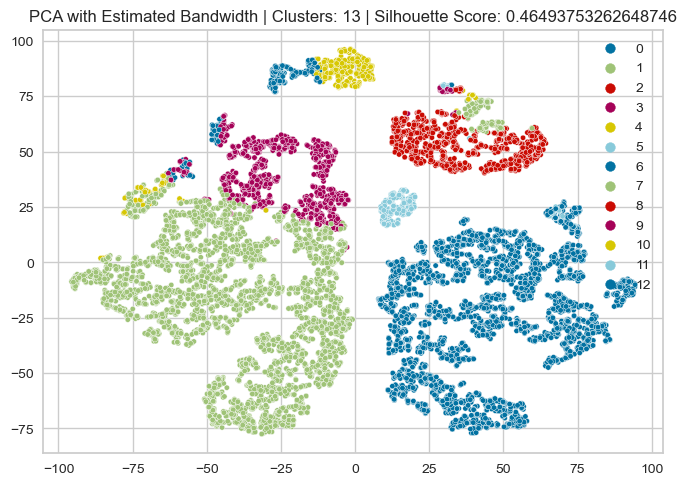

In [ ]:
# 1. Apply Mean Shift clustering with PCA and estimated bandwidth
pca = PCA(n_components=5, random_state=1979)
estimated_bandwidth = estimate_bandwidth(data_sca_tra, quantile=0.3, n_samples=None, random_state=1979, n_jobs=-1)
labels_pca, sil_score_pca, data_sca_tra_pca = mean_shift_clusterer(data, random_state=1979, bandwidth=estimated_bandwidth, scaler=MaxAbsScaler(), trans=pca)

# 2. Output the results
print("Experiment 1: PCA with Estimated Bandwidth")
print(f"Number of Clusters: {len(np.unique(labels_pca))}")
print(f"Silhouette Score: {sil_score_pca}")

# 3. Visualize the clustering results
colors_pca = sns.color_palette(n_colors=len(np.unique(labels_pca)))
tsne_pca = TSNE(n_components=2, learning_rate='auto', random_state=58).fit_transform(data_sca_tra_pca)
sns.scatterplot(x=tsne_pca[:, 0], y=tsne_pca[:, 1], s=15, hue=labels_pca, palette=colors_pca)
plt.title(f'PCA with Estimated Bandwidth | Clusters: {len(np.unique(labels_pca))} | Silhouette Score: {sil_score_pca}')
plt.show()


Experiment 2: PCA with Kernel and Estimated Bandwidth
Number of Clusters: 3
Silhouette Score: 0.5610111414255783


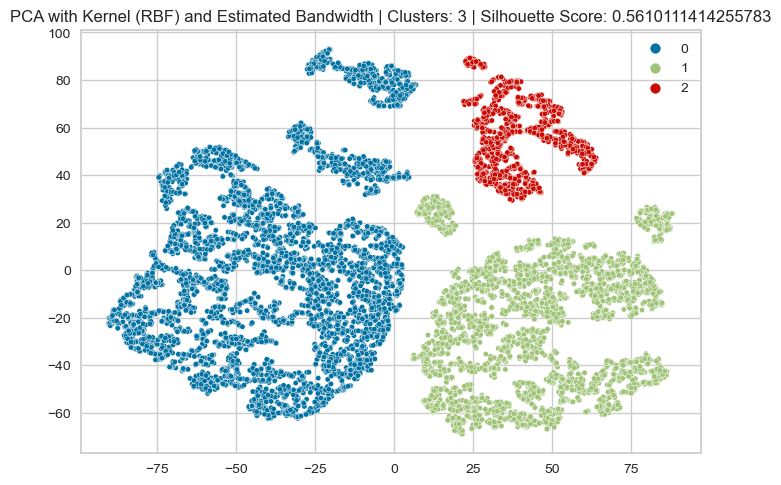

In [ ]:
# 1. Apply Mean Shift clustering with PCA and Kernel (RBF) and estimated bandwidth
kern_pca = KernelPCA(n_components=6, n_jobs=-1, kernel='rbf', random_state=1979)
estimated_bandwidth_kernel = estimate_bandwidth(data_sca_tra, quantile=0.3, n_samples=None, random_state=1979, n_jobs=-1)
labels_kernel, sil_score_kernel, data_sca_tra_kernel = mean_shift_clusterer(data, random_state=1979, bandwidth=estimated_bandwidth_kernel, scaler=MaxAbsScaler(), trans=kern_pca)

# 2. Output the results
print("Experiment 2: PCA with Kernel and Estimated Bandwidth")
print(f"Number of Clusters: {len(np.unique(labels_kernel))}")
print(f"Silhouette Score: {sil_score_kernel}")

# 3. Visualize the clustering results (you can use your existing visualization code)
colors_kernel = sns.color_palette(n_colors=len(np.unique(labels_kernel)))
tsne_kernel = TSNE(n_components=2, learning_rate='auto', random_state=58).fit_transform(data_sca_tra_kernel)
sns.scatterplot(x=tsne_kernel[:, 0], y=tsne_kernel[:, 1], s=15, hue=labels_kernel, palette=colors_kernel)
plt.title(f'PCA with Kernel (RBF) and Estimated Bandwidth | Clusters: {len(np.unique(labels_kernel))} | Silhouette Score: {sil_score_kernel}')
plt.show()